汎用データからQELM <br>
<br>
データ点数N=150(load_iris) <br>
$U(\mathbf{x})$  量子エンコード ; def U_x(x) 　　[N, FEATURE_NUM] -> 量子回路qc <br>
$O$ : 観測値　; counts <br>
$\langle O \rangle$ : 期待値　; expectations　 <br>

変数定義

In [13]:
SIMULATOR_SHOT = 1024 # 量子回路をシミュレーションする回数
FEATURE_NUM = 3 #分類に用いる特徴量

TEST_SIZE = 0.2 #評価する際のtestデータ数の割合

関数の準備

In [14]:
from qiskit import QuantumCircuit
from qiskit_aer import AerSimulator
import numpy as np

"""特徴量xから量子回路を作成し、測定を追加する"""
def U_x(x):
    num_qubits = len(x)
    qc = QuantumCircuit(num_qubits, num_qubits)  # 古典レジスタも作る
    for i in range(num_qubits):
        qc.ry(x[i], i)
    qc.measure(range(num_qubits), range(num_qubits))  # 全量子ビットを測定
    return qc

"""回路qcをシミュレータで実行して期待値を計算"""
def compute_expectations(qc, shots=1024):
    simulator = AerSimulator()
    result = simulator.run(qc, shots=shots).result()
    counts = result.get_counts()
    
    num_qubits = qc.num_qubits
    expectations = np.zeros(num_qubits)
    total_shots = sum(counts.values())

    for bitstring, cnt in counts.items():
        for i, bit in enumerate(reversed(bitstring)):  # ビット順は逆
            if bit == '0':
                expectations[i] += cnt
            else:
                expectations[i] -= cnt
    expectations /= total_shots
    return expectations


データセットの準備 Irisデータから2特徴だけ取る -> 𝑥 ∈ [0, π]

In [15]:
from sklearn.datasets import load_iris
from sklearn.preprocessing import StandardScaler
import numpy as np

# データロード
iris = load_iris()
X = iris.data[:, :FEATURE_NUM]  # 最初の2特徴だけ取る
Y = iris.target

# 標準化（オプション）
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# スケーリング（回転角に合わせて調整）
X_encoded = (X_scaled - X_scaled.min()) / (X_scaled.max() - X_scaled.min()) * np.pi

print(X_encoded.shape)#
print(X_encoded[0])#例えばどういう値があるかの確認
print("true value Y:", Y)



(150, 3)
[0.87188039 1.96349541 0.62193616]
true value Y: [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 2 2 2 2 2 2 2 2 2 2 2
 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2
 2 2]


UMAPで可視化

X_encoded.shape: (150, 3)
X_encoded[0]: [0.87188039 1.96349541 0.62193616]
true value Y: [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 2 2 2 2 2 2 2 2 2 2 2
 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2
 2 2]
X_umap.shape: (150, 2)


/home/yu_iana/anaconda3/lib/python3.12/site-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


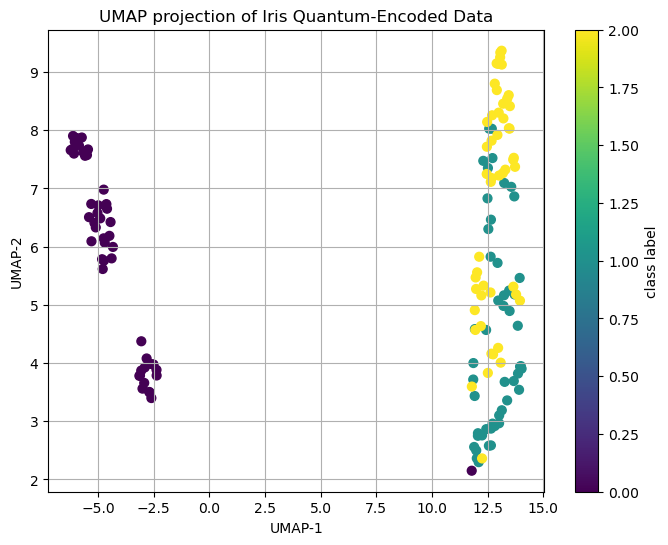

In [16]:
import umap
import matplotlib.pyplot as plt
import numpy as np
from sklearn.datasets import load_iris
from sklearn.preprocessing import StandardScaler

# 標準化
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# スケーリング (0〜πに)
X_encoded = (X_scaled - X_scaled.min()) / (X_scaled.max() - X_scaled.min()) * np.pi

print("X_encoded.shape:", X_encoded.shape)
print("X_encoded[0]:", X_encoded[0])
print("true value Y:", Y)

# --- UMAPで次元削減 ---
reducer = umap.UMAP(random_state=42)
X_umap = reducer.fit_transform(X_encoded)

print("X_umap.shape:", X_umap.shape)  # (150, 2) になるはず

# --- プロット ---
plt.figure(figsize=(8,6))
scatter = plt.scatter(X_umap[:,0], X_umap[:,1], c=Y, cmap='viridis', s=40)
plt.colorbar(scatter, label='class label')
plt.title("UMAP projection of Iris Quantum-Encoded Data")
plt.xlabel("UMAP-1")
plt.ylabel("UMAP-2")
plt.grid(True)
plt.show()

エンコード回路作成 U(x)の作成, 

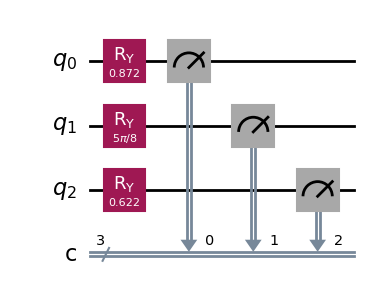

In [17]:
qc = U_x(X_encoded[0]) # 特徴量の数 = Q bit(初期値は0)の回路を作成
qc.draw('mpl') # 回路を描画

In [ ]:
# シミュレータで実行
simulator = AerSimulator()  # methodはautomaticでOK
result = simulator.run(qc, shots=SIMULATOR_SHOT).result()

# 測定結果カウントを取得
counts = result.get_counts()
print(counts)

{'101': 6, '110': 48, '111': 14, '011': 134, '001': 48, '100': 19, '010': 532, '000': 223}


各量子ビットの期待値測定 $\langle O \rangle$　<br>
完全に |0⟩ 状態（z軸上向き）だと、期待値 ⟨Z⟩ = +1 <br>
完全に |1⟩ 状態（z軸下向き）だと、期待値 ⟨Z⟩ = -1 <br>
ちょうど真横（x-y平面上）にいるときは、期待値 ⟨Z⟩ = 0 <br>

Phi.shape: (150, 3)
Phi example [ 0.61914062 -0.390625    0.85742188]
Phi_umap.shape: (150, 2)


/home/yu_iana/anaconda3/lib/python3.12/site-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


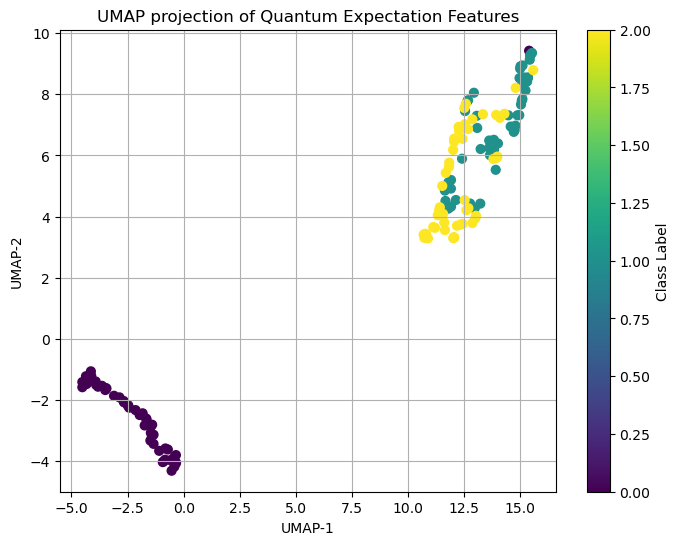

In [23]:
# 全データについて期待値を計算
Phi = []

for x in X_encoded:
    qc = U_x(x)
    expectations = compute_expectations(qc)
    Phi.append(expectations)

Phi = np.array(Phi)

print("Phi.shape:", Phi.shape)  # (150, 3) になるはず
print("Phi example", Phi[0]) 


# UMAP可視化
import umap
import matplotlib.pyplot as plt

# UMAPインスタンス作成
reducer = umap.UMAP(random_state=42)  # 再現性のためseed固定

# ΦをUMAPで2次元に変換
Phi_umap = reducer.fit_transform(Phi)

print("Phi_umap.shape:", Phi_umap.shape)  # (150, 2) になるはず

# プロット
plt.figure(figsize=(8,6))
scatter = plt.scatter(Phi_umap[:,0], Phi_umap[:,1], c=Y, cmap='viridis', s=40)
plt.colorbar(scatter, label='Class Label')
plt.title("UMAP projection of Quantum Expectation Features")
plt.xlabel("UMAP-1")
plt.ylabel("UMAP-2")
plt.grid(True)
plt.show()

QELM(擬似逆行列Wと推論テスト)

In [31]:
# 疑似逆行列を使って重みWを求める
W = np.linalg.pinv(Phi) @ Y
print("Y shape", Y.shape)
print("Phi.shape:", Phi.shape)  # (150, 3) になるはず
print("Learned W:", W.shape)
print("Learned W:", W)

# 推論
Y_pred_continuous = Phi @ W  # 連続値の予測

# 予測をクラス0,1,2に丸める
Y_pred = np.round(Y_pred_continuous).astype(int)
Y_pred = np.clip(Y_pred, 0, 2)  # ラベル範囲にクリップ

# 精度を計算
accuracy = np.mean(Y_pred == Y)
print(f"Training accuracy: {accuracy:.3f}")

Y shape (150,)
Phi.shape: (150, 3)
Learned W: (3,)
Learned W: [-0.37069622  1.23735129 -0.17926373]
Training accuracy: 0.527


[参考] 学習と評価(ELM)

In [ ]:
from sklearn.model_selection import train_test_split
from sklearn.linear_model import Ridge

# 3. 学習データとテストデータに分割
X_train, X_test, y_train, y_test = train_test_split(X_encoded, Y, test_size=0.2, random_state=42)

# 4. 出力層だけ学習：リッジ回帰（最小二乗法＋正則化）
model = Ridge(alpha=1e-3)  # alpha=0なら普通の最小二乗
model.fit(X_train, y_train)

# 5. 予測
y_pred = model.predict(X_test)
y_pred_classes = np.round(y_pred).astype(int)
y_pred_classes = np.clip(y_pred_classes, 0, 2)  # クラスラベル0〜2にクリップ

# 6. 評価
accuracy = np.mean(y_pred_classes == y_test)
print(f"Test accuracy: {accuracy:.3f}")

Test accuracy: 0.967
